In [88]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")


In [125]:
# Setup resonator
resonator_states        = 50
resonator_frequency     = 6.02 * 2 * np.pi    

# Setup drive
drive_amplitude        = 0.1
driving_time           = (0, 300)
simulation_steps       = 1501
drive_frequency        = 6.02 * 2 * np.pi
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)

binwidth = (driving_time[1] - driving_time[0]) / simulation_steps

# Setup the operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

H = (resonator_frequency - drive_frequency)* a_dag * a

H += drive_amplitude * (a_dag + a)

In [126]:
photon_rate = 1 / 10

from qutip import mesolve 
initial_state = qutip.basis(resonator_states, 0)

result_deterministic = mesolve(
    H,
    initial_state,
    np.linspace(*driving_time, simulation_steps),
    c_ops = [np.sqrt(photon_rate) * a],
    e_ops = [a_dag * a, a + a_dag, (1j) * (a - a_dag)],
    progress_bar = True
)


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00
20.1%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.21s. Est. time left: 00:00:00:00
40.0%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.38s. Est. time left: 00:00:00:00
60.0%. Run time:   0.46s. Est. time left: 00:00:00:00
70.0%. Run time:   0.55s. Est. time left: 00:00:00:00
80.0%. Run time:   0.64s. Est. time left: 00:00:00:00
90.0%. Run time:   0.74s. Est. time left: 00:00:00:00
Total run time:   0.82s


Text(0.5, 1.0, 'Deterministic simulation')

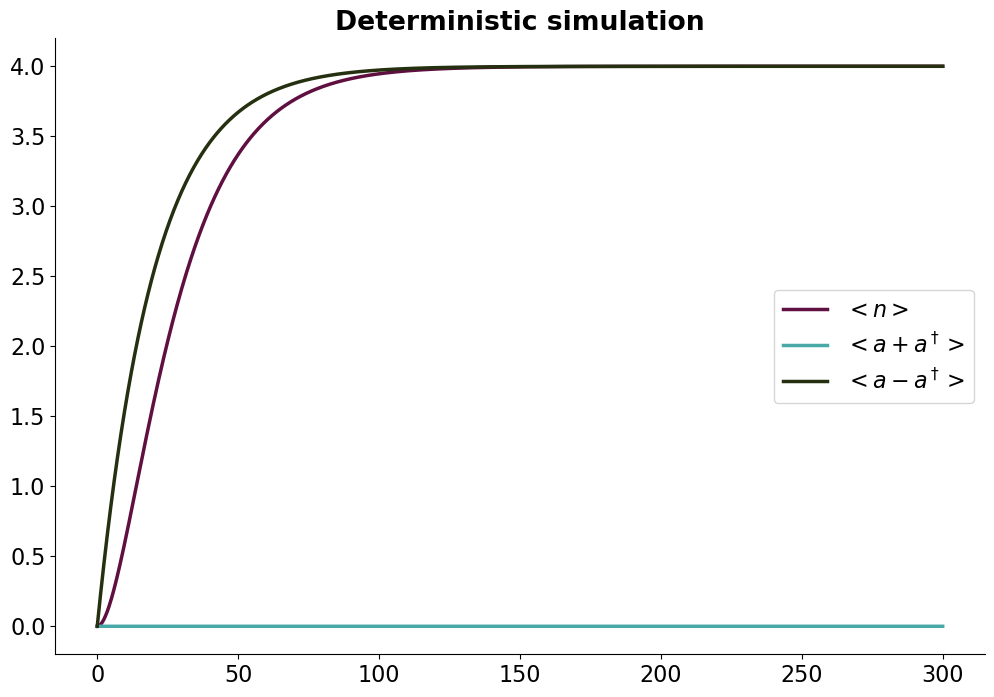

In [127]:
plt.plot(result_deterministic.times, result_deterministic.expect[0], label = "$<n>$")
plt.plot(result_deterministic.times, result_deterministic.expect[1], label = "$<a + a^\dagger>$")
plt.plot(result_deterministic.times, result_deterministic.expect[2], label = "$<a - a^\dagger>$")

plt.legend()
plt.title("Deterministic simulation")

In [107]:
efficiency = 0.75

from qutip import spre, spost, liouvillian, ket2dm, to_super, lindblad_dissipator
from qutip.expect import expect_rho_vec

# Here we define the deterministic part
L = liouvillian(H)
D = lindblad_dissipator(np.sqrt(photon_rate) * a)

# Collect in function
def evolution(time, rho_vec):
    return (L + D) * rho_vec

# Here we define the stochastic part
c = np.sqrt(efficiency * photon_rate) * a

super_c = spre(c) + spost(c.dag())

# Collect in function
def measurement(time, rho_vec):
    expect = expect_rho_vec(super_c.data, rho_vec, False)
    drho   = super_c * rho_vec - expect * rho_vec
    return np.expand_dims(drho, axis = 0)



# Run simulation
from qutip import general_stochastic, parallel_map, operator_to_vector

exp_vals = [spre(a_dag * a), spre(a + a_dag), spre((1j) * (a - a_dag))]

result_stochastic = general_stochastic(
    operator_to_vector(ket2dm(initial_state)),
    np.linspace(*driving_time, simulation_steps),
    evolution,
    measurement,
    e_ops = exp_vals,
    ntraj = 100,
    nsubsteps = 5,
    progress_bar = True,
    map_func = parallel_map,
    solver = "platen",
    # store_all_expect = True,
    dW_factors = [np.sqrt(1 / photon_rate)],
    m_ops = [1j * spre(a - a.dag())],
    store_measurement = True
)

10.0%. Run time:   6.41s. Est. time left: 00:00:00:57
20.0%. Run time:  15.44s. Est. time left: 00:00:01:01
30.0%. Run time:  20.81s. Est. time left: 00:00:00:48
40.0%. Run time:  26.44s. Est. time left: 00:00:00:39
50.0%. Run time:  37.62s. Est. time left: 00:00:00:37
60.0%. Run time:  48.06s. Est. time left: 00:00:00:32
70.0%. Run time:  51.18s. Est. time left: 00:00:00:21
80.0%. Run time:  59.51s. Est. time left: 00:00:00:14
90.0%. Run time:  67.06s. Est. time left: 00:00:00:07
100.0%. Run time:  69.84s. Est. time left: 00:00:00:00
Total run time:  69.94s


(0.0, 8.0)

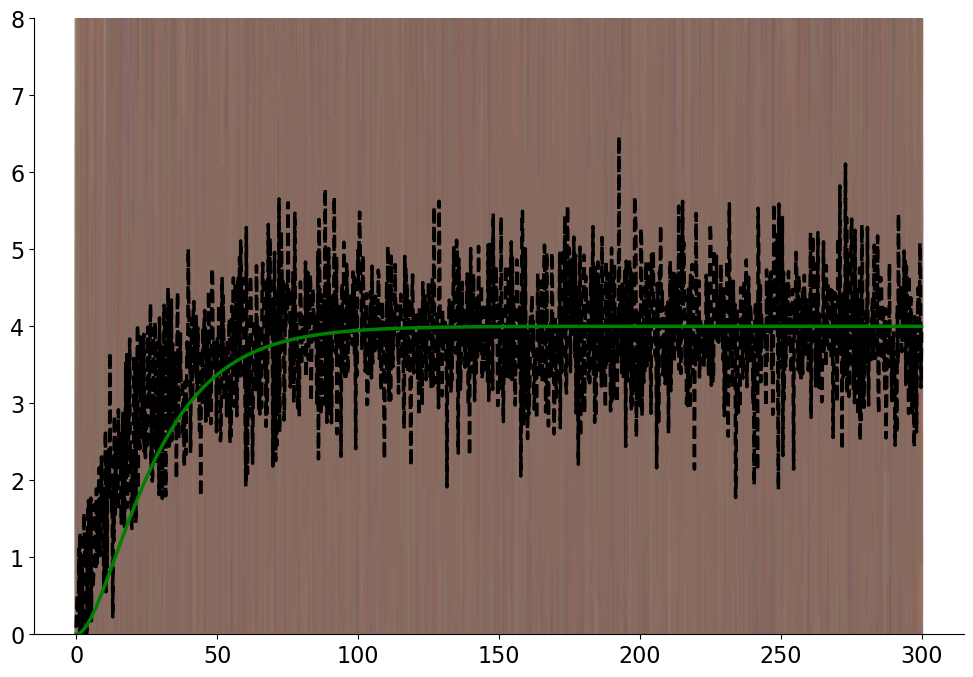

In [108]:
measurements = np.squeeze(np.array(result_stochastic.measurement))
times        = result_stochastic.times

for i in range(result_stochastic.ntraj):
    plt.plot(times, measurements[i, :], alpha = 0.05)

plt.plot(times, measurements.mean(axis = 0), "k--")

# plt.plot(times, np.cumsum(measurements.mean(axis = 0)) / times, "k--")
plt.plot(times, result_stochastic.expect[0], label = "$<n>$", color = "green")

plt.ylim(0, 8)

/tmp/ipykernel_349/207932200.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(times, np.cumsum(measurements[i, :]) * binwidth/ times, alpha = 0.05, color = "C0")
/tmp/ipykernel_349/207932200.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(times, np.cumsum(measurements[i, :]) * binwidth/ times, alpha = 0.05, color = "C0")


(0.0, 8.0)

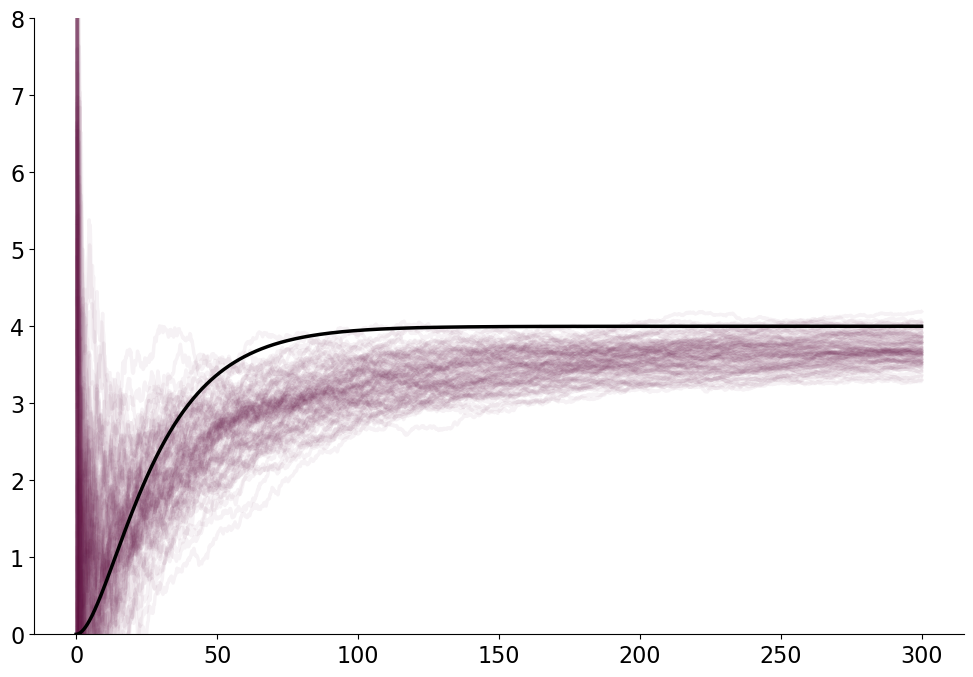

In [109]:
measurements = np.squeeze(np.array(result_stochastic.measurement))
times        = result_stochastic.times
binwidth     = times[1] - times[0]

for i in range(result_stochastic.ntraj):
    plt.plot(times, np.cumsum(measurements[i, :]) * binwidth/ times, alpha = 0.05, color = "C0")

# plt.plot(times, measurements.mean(axis = 0), "k--")

# plt.plot(times, np.cumsum(measurements.mean(axis = 0)) / times, "k--")
plt.plot(times, result_stochastic.expect[0], label = "$<n>$", color = "k")

plt.ylim(0, 8)

/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


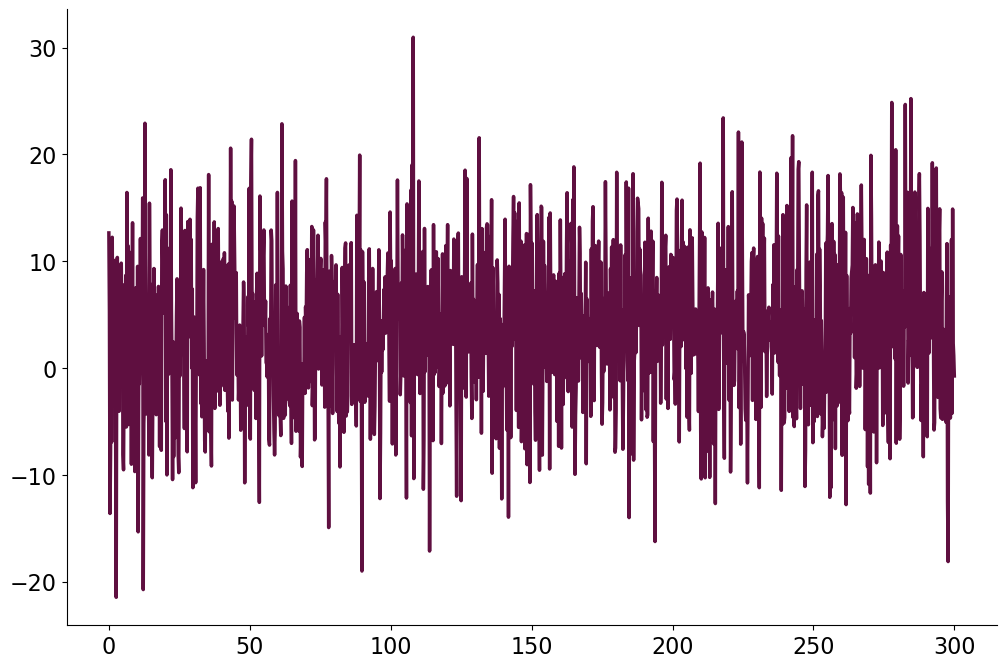

In [103]:
plt.plot(times, measurements[0, :])

Text(0.5, 1.0, 'Stochastic simulation')

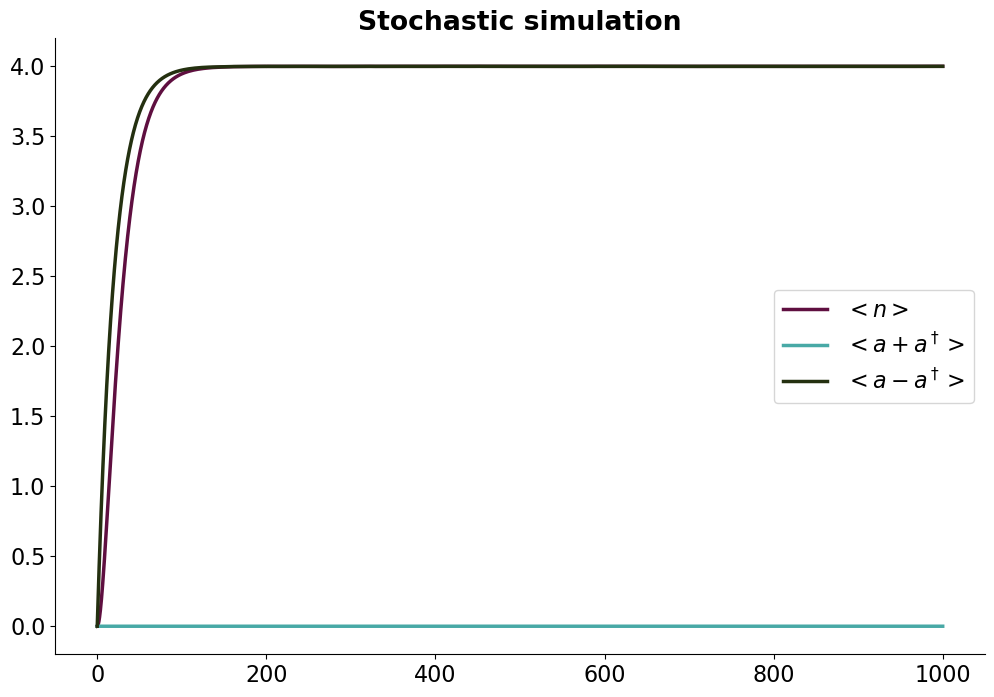

In [80]:
plt.plot(result_stochastic.times, result_stochastic.expect[0], label = "$<n>$")
plt.plot(result_stochastic.times, result_stochastic.expect[1], label = "$<a + a^\dagger>$")
plt.plot(result_stochastic.times, result_stochastic.expect[2], label = "$<a - a^\dagger>$")

plt.legend()
plt.title("Stochastic simulation")